This simple notebook demonstrates how users can interleave text, code, and results in a single document. We start with a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values. The Jupyter notebook allows us to express that mathematically, using the typesetting language $\LaTeX{}$: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

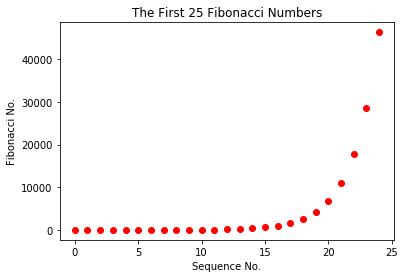

In [4]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
## uncomment the following call to ax.plot() (by removing the leading '#') and select 
## 'Cell > Run All' (in Binder) or 'Run > Run All Cells' (Jupyter) to change the graph below
# ax.plot (range(25), ar)
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

Anything you can do programmatically, can be documented in a notebook. Here we'll do some simple sequence analysis with Biopython. The following example is adapted from the [Biopython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). 

First, we'll read in a Genbank-formatted file, which represents a circular DNA, called a plasmid, from the bacterium, *Yersinia pestis*.

In [5]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq3

record = SeqIO.read("NC_005816.gb", "genbank")
record.seq

Seq('TGTAACGAACGGTGCAATAGTGATCCACACCCAACGCCTGAAATCAGATCCAGG...CTG', IUPACAmbiguousDNA())

How long is the DNA, and how many sequence features are present?

In [6]:
print("Length:", len(record.seq), "bp")
print("Number of features:", len(record.features))

Length: 9609 bp
Number of features: 41


How many genes are present on this plasmid?

In [7]:
nGenes = 0
for feat in record.features:
    if (feat.type == "CDS"):
        nGenes += 1

print (nGenes, "genes found\n")

10 genes found



There are 10 genes. Let's focus on *pim*, which encodes the *Y. pestis* 'pesticin immunity protein'.

In [8]:
# adapted from https://www.biostars.org/p/249500/
for gb_record in SeqIO.parse("NC_005816.gb", "genbank"):
    # now do something with the record
    for feat in gb_record.features:
        if feat.type == "CDS":
            product = feat.qualifiers['product'][0]
            if product == 'pesticin immunity protein' :
                print ("pim gene location\nStart:", feat.location.start, "\nEnd:", feat.location.end)

pim gene location
Start: 4342 
End: 4780


These data show us that the *pim* gene is located between bases 4342 and 4780. Let's retrieve that segment ...

In [9]:
pim = record[4342:4780]

... and translate it.

In [10]:
print (pim.seq.translate())

MGGGMISKLFCLALIFLSSSGLAEKNTYTAKDILQNLELNTFGNSLSHGIYGKQTTFKQTEFTNIKSNTKKHIALINKDNSWMISLKILGIKRDEYTVCFEDFSLIRPPTYVAIHPLLIKKVKSGNFIVVKEIKKSIPGCTVYYH*


We can also view that in 3-letter code, which may be easier to read...

In [20]:
# add a 'custom_map' parameter because by default, seq3 uses 'Ter' for stop codons.
print (seq3(pim.seq.translate(), custom_map={"*": "***"}))

MetGlyGlyGlyMetIleSerLysLeuPheCysLeuAlaLeuIlePheLeuSerSerSerGlyLeuAlaGluLysAsnThrTyrThrAlaLysAspIleLeuGlnAsnLeuGluLeuAsnThrPheGlyAsnSerLeuSerHisGlyIleTyrGlyLysGlnThrThrPheLysGlnThrGluPheThrAsnIleLysSerAsnThrLysLysHisIleAlaLeuIleAsnLysAspAsnSerTrpMetIleSerLeuLysIleLeuGlyIleLysArgAspGluTyrThrValCysPheGluAspPheSerLeuIleArgProProThrTyrValAlaIleHisProLeuLeuIleLysLysValLysSerGlyAsnPheIleValValLysGluIleLysLysSerIleProGlyCysThrValTyrTyrHis***


And we can double-check our translation by viewing the region in Genbank format. Notice that our translation matches the `/translation` field in the Genbank record.

In [12]:
print(pim.format("genbank"))

LOCUS       NC_005816                438 bp    DNA              UNK 01-JAN-1980
DEFINITION  Yersinia pestis biovar Microtus str. 91001 plasmid pPCP1, complete
            sequence.
ACCESSION   NC_005816
VERSION     NC_005816.1
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     gene            1..438
                     /gene="pim"
                     /locus_tag="YP_pPCP05"
                     /db_xref="GeneID:2767712"
     CDS             1..438
                     /gene="pim"
                     /locus_tag="YP_pPCP05"
                     /note="similar to many previously sequenced pesticin
                     immunity protein entries of Yersinia pestis plasmid pPCP,
                     e.g. gi| 16082683|,ref|NP_395230.1| (NC_003132) ,
                     gi|1200166|emb|CAA90861.1| (Z54145 ) , gi|1488655|
                     emb|CAA63439.1| (X92856) , gi|2996219|gb|AAC62543.1|
                     (AF053945) , and gi|5763814|

Jupyter also supports interactive data exploration. Here we'll add an interactive map, just as in our June [mapping feature](https://www.nature.com/articles/d41586-018-05331-6) -- something you might do when working with geospatial data. This requires the Python Leaflet library, folium. (**Uncomment the following cell (by deleting the leading `#`) if you don't have folium installed.**)

In [13]:
# !pip install folium

In [14]:
import folium

Now we create a simple map: a few points in London, Oxford and Cambridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). 

In [15]:
import pandas as pd

# create a data frame of locations
name = ["Nature", "Francis Crick Institute", "University College London", 
        "MRC Laboratory for Molecular Cell Biology", "Kings College London",
       "Imperial College London", "Cambridge University", "Oxford University",
       "Platform 9-3/4"]
lat = [51.533925,51.531877,51.524486,51.524435,51.511573,51.498780,52.206960,51.754843,51.532349]
long = [-0.121553,-0.128767,-0.133997,-0.132495,-0.116083,-0.174888,0.115034,-1.254302,-0.123806]

df = pd.DataFrame({'Name': name, 'Lat': lat, 'Long': long})

In [16]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for index,row in df.iterrows():
    folium.CircleMarker(
    location=[row['Lat'], row['Long']],
    popup=row['Name'],
    color=('crimson' if row['Name'] == 'Nature' else 'blue'),
    fill=False,
    ).add_to(m)

folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map. **Note that this map is interactive**: you can zoom, pan, click the points of interest, and alternate between the two layers (by clicking on the tiles icon in the upper-right corner of the map).

In [17]:
m

Document our session, for [computational reproducibility](https://www.nature.com/articles/d41586-018-05990-5)!

In [18]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.7.0-x86_64-i386-64bit',
 'sys_executable': '/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.3 | packaged by conda-forge | (default, Oct  5 2017, '
                '19:18:17) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'}


In [19]:
!pip freeze | grep -E 'folium|matplotlib|pandas|bio'

biopython==1.70
folium==0.6.0
matplotlib==2.1.0
pandas==0.20.3
